In [1]:
import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution3D, MaxPooling3D, UpSampling3D, GlobalAveragePooling3D, Dense, Flatten, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.optimizers import SGD, Adam, Nadam

from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [6]:
import data
import importlib; importlib.reload(data)
import random
import scipy.ndimage.interpolation

vsize = np.asarray([32,32,32])

df_nodes = data.ndsb17_get_df_nodes() 
df_nodes = df_nodes[(df_nodes["diameter_mm"]>10)]

patient_ids = data.ndsb17_get_patient_ids()

X_nodules, diams = data.ndsb17_get_all_nodules(vsize, df_nodes)

def make_augmented(vsize, volume, X_nodules):
    idx = random.choice(range(len(X_nodules)))
    nodule = X_nodules[idx]
    # randomly flip or not flip each axis
    if random.choice([True, False]):
        nodule = nodule[::-1,:,:]
    if random.choice([True, False]):
        nodule = nodule[:,::-1,:]
    if random.choice([True, False]):
        nodule = nodule[:,:,::-1]
    mask = data.compose_make_mask(vsize, diam=diams[idx]+6, sigma=(diams[idx]+6)/8)
    volume_aug = data.compose_max2(volume, nodule, mask)
    return volume_aug

def sample_generator(vsize, patient_ids, X_nodules, diams):
    n = 0
    n_aug = 0

    central_mask = data.compose_make_mask(vsize, diam=6+6, sigma=(6+6)/8)
    
    while True:
        if n % 1000 == 0:
            try:
                pid = random.choice(patient_ids)
                image_ = data.ndsb17_get_image(pid)
                segmented_image_ = data.ndsb17_get_segmented_image(pid)

                image, segmented_image = image_, segmented_image_
                n+=1
                # segpack = np.packbits(segmented_image, axis=0)
                # info = data.luna16_get_info(pid)
            except Exception as e:
                #print(pid, repr(e))
                continue
            
        pos = np.asarray([ np.random.randint(k, image.shape[k] - vsize[k]) for k in range(3) ])
        segmented_volume = segmented_image[pos[0]:pos[0]+vsize[0], pos[1]:pos[1]+vsize[1], pos[2]:pos[2]+vsize[2]]
        if np.count_nonzero(segmented_volume) == 0:
            continue
#         segpack_volume = segpack[pos[0]//8:(pos[0]+vsize[0])//8, pos[1]:pos[1]+vsize[1], pos[2]:pos[2]+vsize[2]]
#         if np.count_nonzero(segpack_volume) == 0:
#            continue
        volume = image[pos[0]:pos[0]+vsize[0], pos[1]:pos[1]+vsize[1], pos[2]:pos[2]+vsize[2]]
#         overlap = np.mean(segmented_volume)
#         density = np.mean(volume)
        central_density = np.mean((volume+1000) * central_mask) / np.mean(central_mask) - 1000
    
        is_augmented = False
        if central_density < -500 and np.random.choice([True, False]):
            volume = make_augmented(vsize, volume, X_nodules)
            is_augmented = True
            n_aug += 1
            
        n+=1

        yield volume, is_augmented
        
def batch_generator(vsize, patient_ids, X_nodules, diams):
    gen = sample_generator(vsize, patient_ids, X_nodules, diams)
    batch_size = 64
    while True:
        X = np.zeros((batch_size, 32,32,32,1), dtype=np.float32)
        y = np.zeros((batch_size, 2), dtype=np.int)
        for n in range(batch_size):
            volume, is_augmented = next(gen)
            X[n,:,:,:,0] = volume
            if is_augmented:
                y[n,1] = 1
            else:
                y[n,0] = 1
        X = (X - X_mean)/X_std
        X = scipy.ndimage.interpolation.zoom(X, (1, 0.5, 0.5, 0.5, 1), order=1)
        yield X, y

FileNotFoundError(2, 'No such file or directory')


In [7]:
gen = batch_generator(vsize, patient_ids, X_nodules[:-50], diams[:-50])

In [9]:
X, y = next(gen)
X.shape

/home/alex/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:571: RuntimeWarning: invalid value encountered in true_divide
  zoom = (numpy.array(input.shape) - 1) / zoom_div


(64, 16, 16, 16, 1)

In [10]:
for n in range(100):
    X, y = next(gen)
    if X.shape != (64,16,16,16,1):
        print(X.shape)

/home/alex/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:571: RuntimeWarning: invalid value encountered in true_divide
  zoom = (numpy.array(input.shape) - 1) / zoom_div


In [12]:
X_big = []
for n in range(100):
    X, y = next(gen)
    X_big.append(X)

/home/alex/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:571: RuntimeWarning: invalid value encountered in true_divide
  zoom = (numpy.array(input.shape) - 1) / zoom_div


In [13]:
X_mean = np.mean(X_big)
X_std = np.std(X_big)
print(X_mean, X_std)

-298.099 436.168


In [5]:
# X_mean, X_std = -378.9, 475.913 # for LUNA16
X_mean, X_std = -298.099, 436.168


In [12]:
vsize = (16, 16, 16)



def model3d(vsize, do_features=False):
    inputs = Input(vsize + (1,))
    sz = 48
    alpha = 1.5
    
    def conv3dparams(**replace_params):
        params = { 'activation':ELU(), 'border_mode':'valid', 'init': 'he_normal' }
        params.update(replace_params)
        return params

    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(inputs)
    x = BatchNormalization()(x)

    sz = int(sz * alpha)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    # x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    sz = int(sz * alpha)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    # x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    sz = int(sz * alpha)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 3, 3, 3, **conv3dparams())(x)
    x = BatchNormalization()(x)
    # x = MaxPooling3D(pool_size=(2, 2, 2))(x)

    sz = int(sz * alpha)
    # x = Convolution3D(sz, 3, 3, 3, **conv3dparams)(x)
    # x = Convolution3D(sz, 3, 3, 3, **conv3dparams)(x)
    # x = BatchNormalization()(x)

    x = Convolution3D(sz, 2, 2, 2, **conv3dparams())(x)
    x = BatchNormalization()(x)
    x = Convolution3D(sz, 1, 1, 1, **conv3dparams(border_mode='same'))(x)
    x = BatchNormalization()(x)
    x = Convolution3D(2, 1, 1, 1, **conv3dparams(activation='linear', border_mode='same'))(x)
    if not do_features:
        x = Flatten()(x)
        x = Activation('softmax')(x)

    model = Model(input=inputs, output=x)

    return model



In [12]:
model = model3d(vsize)
print(model.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 16, 16, 16, 1) 0                                            
____________________________________________________________________________________________________
convolution3d_1 (Convolution3D)  (None, 14, 14, 14, 48 1344        input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 14, 14, 14, 48 192         convolution3d_1[0][0]            
____________________________________________________________________________________________________
convolution3d_2 (Convolution3D)  (None, 12, 12, 12, 72 93384       batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [14]:
#sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')

batch_size=64

h = model.fit_generator(
    gen,
    10000,
    nb_epoch=100,
    verbose=1)

Epoch 1/100


/home/alex/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:571: RuntimeWarning: invalid value encountered in true_divide
  zoom = (numpy.array(input.shape) - 1) / zoom_div


10048/10000 [==============================] - 28s - loss: 0.1499 - acc: 0.9489      

/home/alex/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


 1856/10000 [====>.........................] - ETA: 25s - loss: 0.1334 - acc: 0.9547

KeyboardInterrupt: 

In [ ]:
h.history

In [ ]:
from pylab import *
%matplotlib inline

In [ ]:
plot(h.history["acc"])

In [ ]:
plot(h.history["loss"])

In [ ]:
import data

In [ ]:
pid = data.luna16_get_patient_ids()[0]

In [ ]:
image = data.luna16_get_image(pid)

In [13]:
def preprocess(image):
    return (image - X_mean) / X_std

In [ ]:
def preprocess2(image):
    image = np.clip(image, -1000, 100).astype(np.float32)
    return (image - np.mean(image)) / np.std(image)

In [ ]:
model.save_weights('tmp.h5')

In [14]:
model2 = model3d((64,64,64), do_features=True)

In [15]:
# NOTE loading by_name=True fails, because the auto-generated layer names are counting up in keras for each layer class globally
# NOTE on the other hand plain loading works, since the missing top two layers don't have weights
model2.load_weights('tmp2.h5')

In [ ]:
model2.summary()

In [ ]:
def softmax(x):
    return np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)))

In [97]:
#pid = data.luna16_get_patient_ids()[0]
pid = df_nodes.iloc[11]["pid"]

In [98]:
image = data.ndsb17_get_image(pid)
image = preprocess(image)
info = data.ndsb17_get_info(pid)


In [99]:
import scipy.ndimage.interpolation
image_h = scipy.ndimage.interpolation.zoom(image, (0.5, 0.5, 0.5), order=1)

/home/alex/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [100]:
image_h.shape

(154, 178, 178)

In [19]:
def softmax_activations(x):
    r = x.reshape((-1,2))
    r_max = np.max(r, axis=-1)
    r_max = r_max[...,None]
    r_sum = np.sum(np.exp(r - r_max), axis=-1)
    r_sum = r_sum[...,None]
    p = np.exp(r - r_max) / r_sum
    p = p.reshape(x.shape)
    return p

In [38]:
def make_full_result(image):
    full_result = np.zeros((image.shape[0]+64, image.shape[1]+64, image.shape[2]+64, 2))
    s = 49
    d = 64
    for i in range(0, int(np.ceil(image.shape[0]/s))):
        for j in range(0, int(np.ceil(image.shape[1]/s))):
            for k in range(0, int(np.ceil(image.shape[2]/s))):
                input_ = image[i*s:i*s+d,j*s:j*s+d,k*s:k*s+d]
                if input_.shape != (d,d,d):
                    input_ = np.pad(input_, ((0, d-input_.shape[0]), (0, d-input_.shape[1]), (0, d-input_.shape[2])), 'constant')
                result = model2.predict(input_.reshape((1,d,d,d,1)), batch_size=1)
                full_result[i*s:(i+1)*s, j*s:(j+1)*s, k*s:(k+1)*s,:] = result
    return full_result

In [101]:
full_result = make_full_result(image_h)

In [102]:
full_result_p = softmax_activations(full_result)

In [23]:
from pylab import imshow, figure, colorbar, hist
%matplotlib inline

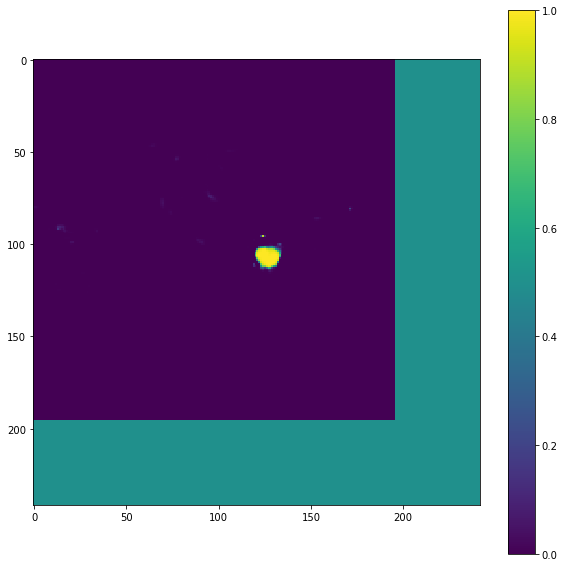

In [107]:
figure(figsize=(10,10))
imshow(full_result_p[image_h.shape[0]-25-8,:,:,1], vmax=1)
colorbar()

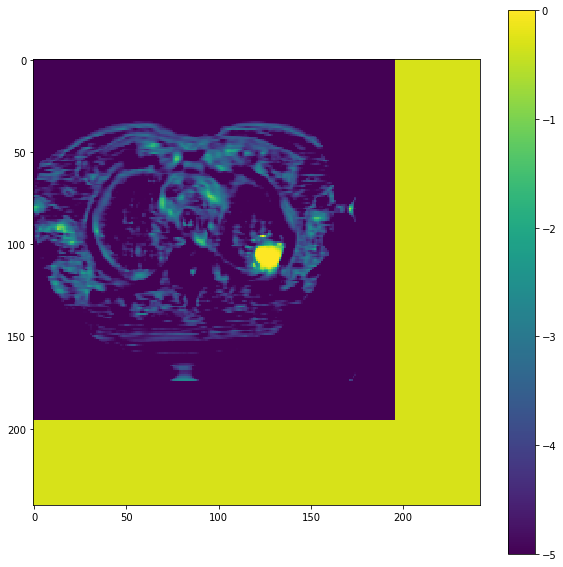

In [108]:
figure(figsize=(10,10))
imshow(np.log10(full_result_p[image_h.shape[0]-25-8,:,:,1]), vmax=0, vmin=-5)
colorbar()

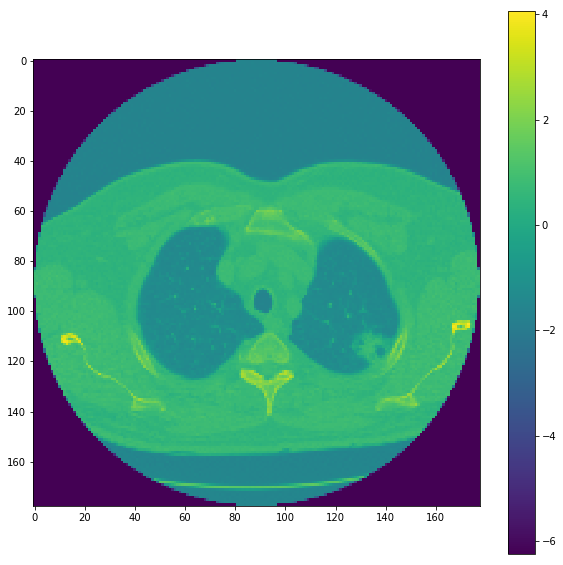

In [106]:
figure(figsize=(10,10))
imshow(image_h[-25])
colorbar()

In [ ]:
patient_ids = data.luna16_get_patient_ids()
pid = [ x for x in patient_ids if in '5b41250' ][0]

In [ ]:
image = np.load('5b412509bc40a3aeb3b5efef1fdfcfc9.npy', mmap_mode='r')
image = preprocess(image)

In [ ]:
image.shape

In [111]:
vsize

(16, 16, 16)

In [ ]:
128 // 10

In [113]:
model = model3d(vsize)
model.load_weights('tmp2.h5')

In [109]:
tmp_false = np.zeros((10000,16,16,16,1), dtype=np.float32)
n = 0
while n < 10000:
    x,y = next(gen)
    for i in range(x.shape[0]):
        if y[i,0] == 1:
            tmp_false[n] = x[i]
            n += 1
            
    

/home/alex/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:571: RuntimeWarning: invalid value encountered in true_divide
  zoom = (numpy.array(input.shape) - 1) / zoom_div


IndexError: index 10000 is out of bounds for axis 0 with size 10000

In [114]:
tmp = np.stack(X_nodules[-50:])[...,None]
tmp = preprocess(tmp)
tmp = scipy.ndimage.interpolation.zoom(tmp, (1, 0.5, 0.5, 0.5, 1), order=1)

p = model.predict(np.concatenate((tmp_false, tmp)))

/home/alex/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:571: RuntimeWarning: invalid value encountered in true_divide
  zoom = (numpy.array(input.shape) - 1) / zoom_div


In [115]:
y_true = np.zeros(p.shape[0])
y_true[10000:] = 1

In [117]:
np.count_nonzero(p[:,1]>0.50)

89

In [ ]:
import random

In [ ]:
vsize = np.asarray([32,32,32])


In [118]:
import sklearn.metrics

NameError: name 'xlabel' is not defined

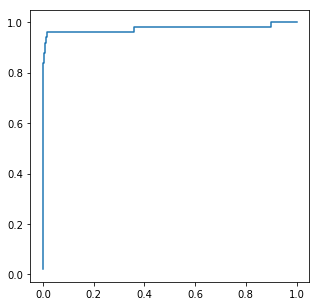

In [123]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, p[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)

figure(figsize=(5,5))
plot(fpr, tpr)
xlabel('False Positive')
ylabel('True Positive')

In [120]:
fpr[:40]

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         2.00000000e-04,   2.00000000e-04,   1.40000000e-03,
         1.40000000e-03,   1.50000000e-03,   1.50000000e-03,
         1.70000000e-03,   1.70000000e-03,   1.90000000e-03,
         1.90000000e-03,   4.60000000e-03,   4.60000000e-03,
         5.70000000e-03,   5.70000000e-03,   7.30000000e-03,
         7.30000000e-03,   1.03000000e-02,   1.03000000e-02,
         1.26000000e-02,   1.26000000e-02,   1.47000000e-02,
         1.47000000e-02,   1.78300000e-01,   1.78500000e-01,
         2.29300000e-01,   2.29500000e-01,   2.44700000e-01,
         2.44900000e-01,   3.18300000e-01,   3.18500000e-01,
         3.57500000e-01,   3.57500000e-01,   8.99000000e-01,
         8.99000000e-01,   1.00000000e+00])

In [121]:
tpr[:40]

array([ 0.02,  0.06,  0.68,  0.68,  0.76,  0.76,  0.78,  0.78,  0.8 ,
        0.8 ,  0.82,  0.82,  0.84,  0.84,  0.86,  0.86,  0.88,  0.88,
        0.9 ,  0.9 ,  0.92,  0.92,  0.94,  0.94,  0.96,  0.96,  0.96,
        0.96,  0.96,  0.96,  0.96,  0.96,  0.96,  0.96,  0.98,  0.98,
        1.  ,  1.  ])

In [122]:
from pylab import plot

In [ ]:
p[:,1]

In [96]:
df_nodes.iloc[11]

pid            0c0de3749d4fe175b7a5098b060982a1
X                                           388
Y                                           330
Im                                           20
X, mm                                       NaN
Y, mm                                       NaN
Z, mm                                       NaN
Size, cm                                    2.8
Cancer                                        *
Misc                                        NaN
Unnamed: 10                                 NaN
diameter_mm                                  28
Name: 167, dtype: object

In [104]:
info

{'do_flip_z': True,
 'spacing': [2.5, 0.693359, 0.693359],
 'spacing_1mm': [0.9983766233766235, 0.9999994591549295, 0.9999994591549295]}

In [44]:
image.shape

(390, 355, 355)

In [89]:
full_result_p.shape

(242, 234, 234, 2)